In [1]:
# Add path to src/CARPy, in case notebook is running locally
import os, sys, warnings
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..\\..\\..\\..\\src")))
warnings.simplefilter("ignore")  # <-- Suppress warnings

# Day-to-day Wind Trends

Import data for the analysis, graciously obtained from https://www.visualcrossing.com/weather/weather-data-services

In [2]:
import pandas as pd

dfs = dict()

# Read data for Dover
df1 = pd.read_csv("./dover 2022-01-01 to 2022-12-31.csv")
df2 = pd.read_csv("./dover 2023-01-01 to 2023-12-31.csv")
df = pd.concat((df1, df2), ignore_index=True)
dfs["Dover"] = {"lat": 51.123993, "lon": 1.311973, "df": df}

# Read data for ...

## Global Wind Direction

Templated analysis from https://python-windrose.github.io/windrose/usage-output.html

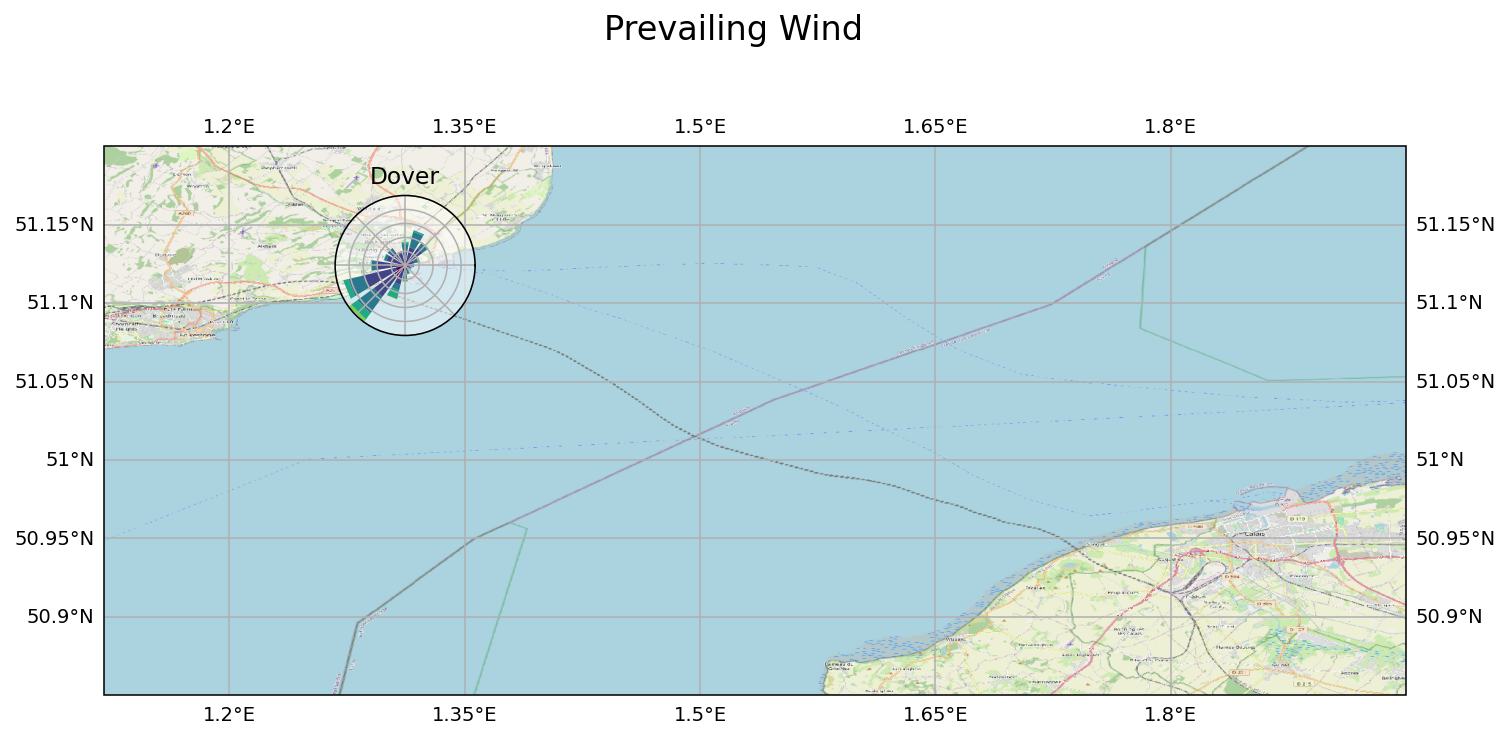

In [3]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import windrose

minlat, maxlat, minlon, maxlon = (51.20, 50.85, 1.12, 1.95)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 6), dpi=140)
fig.suptitle("Prevailing Wind", fontsize="xx-large")
# Draw main ax on top of which we will add windroses
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
# main_ax.coastlines()

request = cimgt.OSM()
main_ax.add_image(request, 12)

for (station, station_data) in dfs.items():
    
    wd = station_data["df"]["winddir"]
    ws = station_data["df"]["windspeed"]
    # ws = station_data["df"]["windgust"]
    
    # Inset axe it with a fixed size
    size_in = 1  # size in inches
    wrax = inset_axes(
        main_ax,
        width=size_in,
        height=size_in,
        loc="center",  # center bbox at given position
        bbox_to_anchor=(station_data["lon"], station_data["lat"]),  # position of the axe
        bbox_transform=main_ax.transData,  # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,  # specify the class of the axe
    )
    wrax.patch.set_alpha(0.5)

    wrax.bar(wd, ws)
    wrax.tick_params(labelleft=False, labelbottom=False)
    wrax.set_title(station)

## Wind Direction and Speed by Station

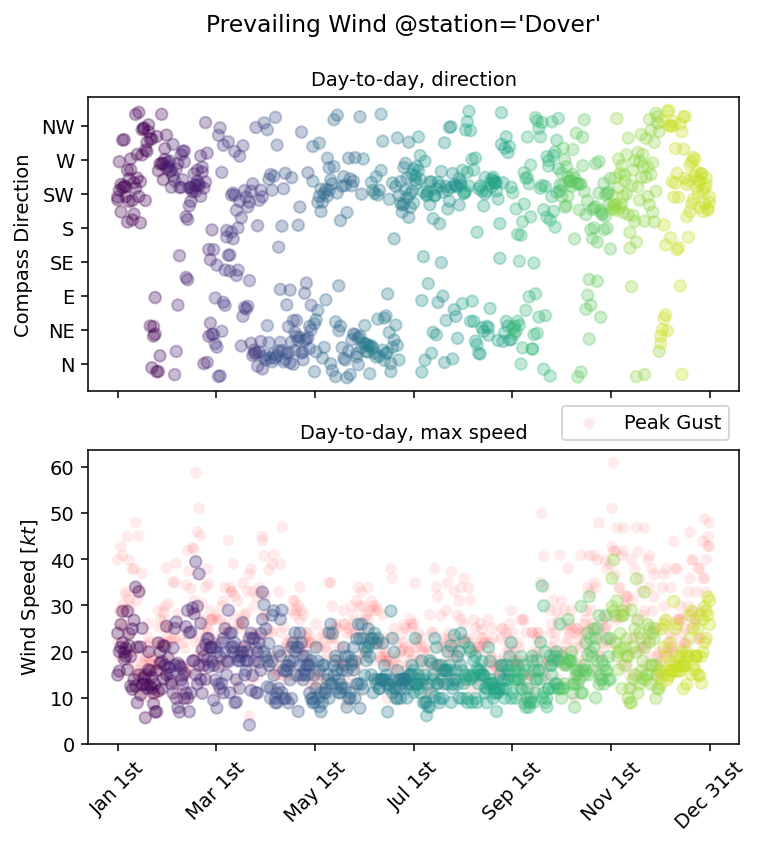

In [4]:
from carpy.utility import Quantity

wind_unit = "kt"

cmap = plt.get_cmap("viridis")

for (station, station_data) in dfs.items():
    
    fig, axs = plt.subplots(2, 1, dpi=140, figsize=(6, 6), sharex=True)
    fig.suptitle(f"Prevailing Wind @{station=}")
    
    dt = np.array(station_data["df"]["datetime"], dtype="datetime64")
    wd = (station_data["df"]["winddir"] + 22.5) % 360 - 22.5  # NNW data should plot near N, not NW
    ws = Quantity(station_data["df"]["windspeed"], "km hr^{-1}").to(wind_unit)
    wg = Quantity(station_data["df"]["windgust"], "km hr^{-1}").to(wind_unit)
    
    month_idx = dt.astype("datetime64[M]").astype(int) % 12
    common_kw = {"alpha": 0.3, "c": cmap(month_idx / 12)}
    months = (dt - dt.astype("datetime64[Y]")).astype("datetime64[D]")
    
    axs[0].scatter(months, wd, **common_kw)
    axs[0].set_title("Day-to-day, direction", fontsize="medium")
    axs[0].set_yticks(np.arange(0, 360, 45))  # Locate the y ticks
    axs[0].set_yticklabels("N,NE,E,SE,S,SW,W,NW".split(","))
    axs[0].set_ylabel("Compass Direction")
    
    axs[1].scatter(months, ws, **common_kw, zorder=20)
    axs[1].scatter(months, wg, c="r", label="Peak Gust", zorder=10, alpha=0.08, ec=None)
    axs[1].set_title("Day-to-day, max speed", fontsize="medium")
    axs[1].set_ylabel(f"Wind Speed [${wind_unit}$]")
    axs[1].legend(bbox_to_anchor=(1.0, 1.0), loc="lower right")
    axs[1].set_ylim(0, None)
    
    axs[-1].set_xticks(np.linspace(0, np.max(months.astype(int)), 7))
    axs[-1].set_xticklabels(
        [f"{x}1st" for x in "Jan ,Mar ,May ,Jul ,Sep ,Nov ,Dec 3".split(",")],
        rotation=45
    )
    

## Precipitation

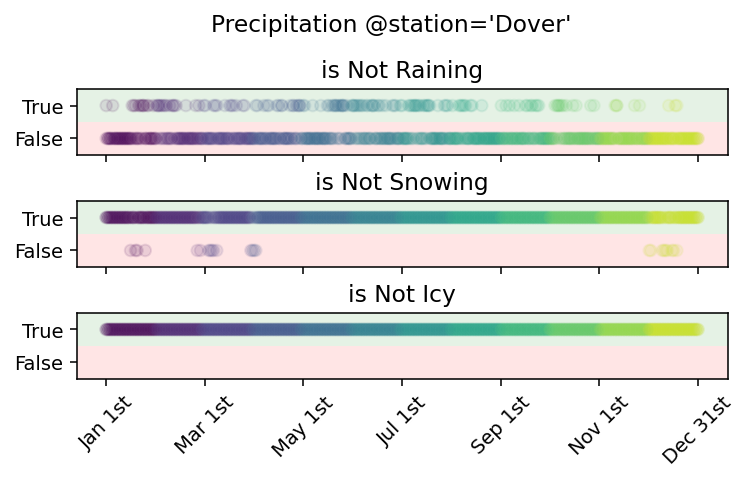

In [5]:
for (station, station_data) in dfs.items():
    
    fig, axs = plt.subplots(3, 1, dpi=140, figsize=(6, 3), sharex=True)
    fig.suptitle(f"Precipitation @{station=}")
    fig.subplots_adjust(hspace=0.7, top=0.8)
    
    dt = np.array(station_data["df"]["datetime"], dtype="datetime64")
    pt = station_data["df"]["preciptype"]

    month_idx = dt.astype("datetime64[M]").astype(int) % 12
    common_kw = {"alpha": 0.1, "c": cmap(month_idx / 12)}
    months = (dt - dt.astype("datetime64[Y]")).astype("datetime64[D]")
    
    rainy = pt.str.contains("rain").fillna(False)
    axs[0].scatter(months, ~rainy, **common_kw)
    axs[0].set_title("is Not Raining")
    
    snowy = pt.str.contains("snow").fillna(False)
    axs[1].scatter(months, ~snowy, **common_kw)
    axs[1].set_title("is Not Snowing")
    
    icy = pt.str.contains("icy").fillna(False)
    axs[2].scatter(months, ~icy, **common_kw)
    axs[2].set_title("is Not Icy")
    
    axs[-1].set_xticks(np.linspace(0, np.max(months.astype(int)), 7))
    axs[-1].set_xticklabels(
        [f"{x}1st" for x in "Jan ,Mar ,May ,Jul ,Sep ,Nov ,Dec 3".split(",")],
        rotation=45
    )
    
    for ax in axs.flat:
        ax.set_yticks([0, 1])
        ax.set_yticklabels(["False", "True"])
        ax.set_ylim(-0.5, 1.5)
        ax.set_xlim(ax.get_xlim())
        ax.fill_between(ax.get_xlim(), -0.5, 0.5, fc="red", alpha=0.1, zorder=-10)
        ax.fill_between(ax.get_xlim(), 0.5, 1.5, fc="green", alpha=0.1, zorder=-10)